In [1]:
import datasets
from functools import reduce

dataset = datasets.load_dataset('lecslab/usp-igt')

def split_glosses(row):
    word_glosses = row['pos_glosses'].split()
    glosses = [word.split("-") for word in word_glosses]
    row['glosses_split'] = reduce(lambda a,b:a+["[SEP]"]+b, glosses)
    return row

dataset = dataset.map(split_glosses)
dataset['train'][0]

{'transcription': 'o sey xtok rixoqiil',
 'segmentation': "o' sea x-tok r-ixóqiil",
 'pos_glosses': 'CONJ ADV COM-VT E3S-S',
 'glosses': 'o sea COM-buscar E3S-esposa',
 'translation': 'O sea busca esposa.',
 'glosses_split': ['CONJ',
  '[SEP]',
  'ADV',
  '[SEP]',
  'COM',
  'VT',
  '[SEP]',
  'E3S',
  'S']}

In [31]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=dataset['train']['glosses_split'], window=3, vector_size=1000)

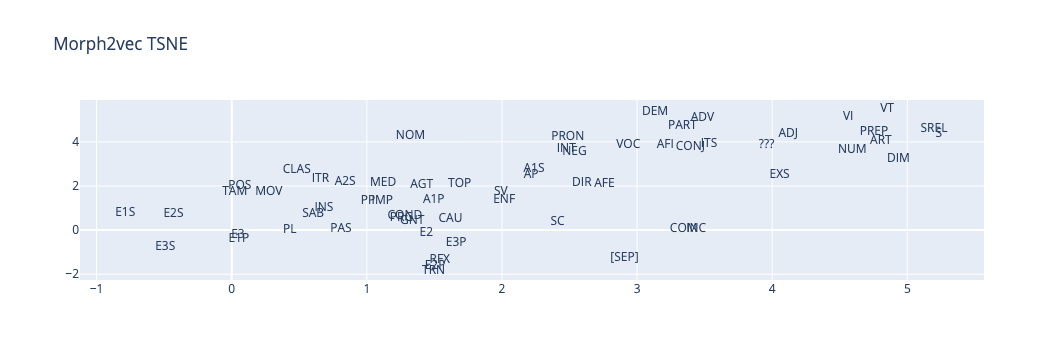

In [32]:
import numpy as np
from sklearn.manifold import TSNE
import plotly

def reduce_dimensions(model):
    num_components = 2  # number of dimensions to keep after compression

    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # apply TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels, tsne


def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Morph2vec TSNE")
    fig.show()
    return fig


x_vals, y_vals, labels, tsne = reduce_dimensions(model)

plot = plot_embeddings(x_vals, y_vals, labels)

In [33]:
guess = model.wv.get_vector('E1S') + (model.wv.get_vector('A1S') - model.wv.get_vector('A2S'))
model.wv.most_similar(positive=[guess], topn=3)

[('E1S', 0.9884843826293945),
 ('A1S', 0.9782494306564331),
 ('AP', 0.9780628681182861)]

  0%|          | 0/50 [00:00<?, ?it/s]

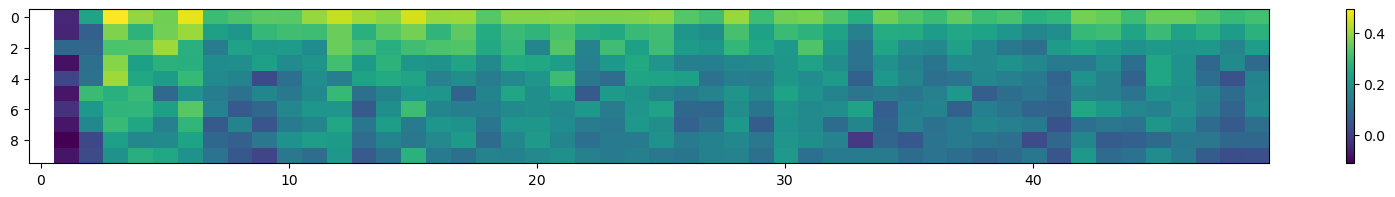

In [59]:
import itertools
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# For Uspanteko, our structure is [Ergative, Absolutive, 1P, 2P, 3P, Si, Pl]
structured_glosses = {
    "A1P": [0, 1, 1, 0, 0, 0, 1],
    "A1S": [0, 1, 1, 0, 0, 1, 0],
    # "A2P": [0, 1, 0, 1, 0, 0, 1],
    "A2S": [0, 1, 0, 1, 0, 1, 0],
    # "E1":  [1, 0, 1, 0, 0, 0, 0],
    "E1P": [1, 0, 1, 0, 0, 0, 1],
    "E1S": [1, 0, 1, 0, 0, 1, 0],
    "E2":  [1, 0, 0, 1, 0, 0, 0],
    "E2P": [1, 0, 0, 1, 0, 0, 1],
    "E2S": [1, 0, 0, 1, 0, 1, 0],
    "E3":  [1, 0, 0, 0, 1, 0, 0],
    "E3P": [1, 0, 0, 0, 1, 0, 1],
    "E3S": [1, 0, 0, 0, 1, 1, 0],
}

def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

def compute_sim_correlation(m):
    gloss_combos = []
    ling_similarity = []
    embed_similarity = []
    
    for gloss1, gloss2 in itertools.combinations(structured_glosses.keys(), 2):
        if gloss1 == gloss2:
            continue
    
        gloss_combos.append(f"{gloss1}, {gloss2}")
        ling_similarity.append(cos_sim(np.array(structured_glosses[gloss1]), np.array(structured_glosses[gloss2])))
        embed_similarity.append(cos_sim(m.wv.get_vector(gloss1), m.wv.get_vector(gloss2)))
    
    return np.corrcoef(np.array(ling_similarity), np.array(embed_similarity))[0, 1]


corrs = np.zeros((50, 10))
for size in tqdm(range(1, 51)):
    for window in range(1, 11):
        m = Word2Vec(sentences=dataset['train']['glosses_split'], window=window, vector_size=size)
        corrs[size-1][window-1] = compute_sim_correlation(m)

plt.figure(figsize = (20,2))
plt.imshow(corrs.transpose(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()

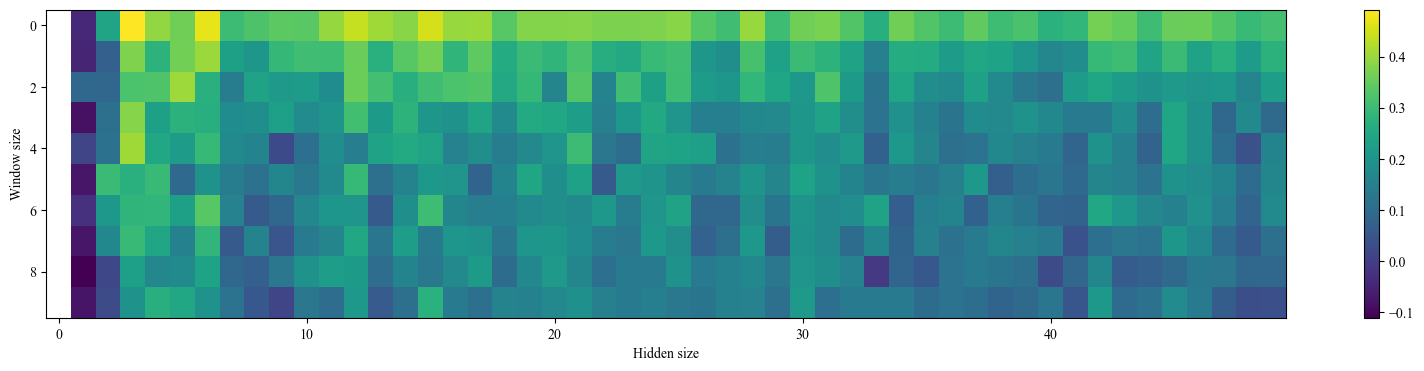

In [72]:
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize = (20,4))
plt.imshow(corrs.transpose(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Hidden size")
plt.ylabel("Window size")

# plt.show()
# plt.show()
plt.savefig("usp_w2v.eps")

In [74]:
from sklearn.cluster import KMeans
from collections import defaultdict

kmeans = KMeans(n_clusters=15).fit(model.wv.vectors)

clusters = defaultdict(lambda: [])

for index, cluster_label in enumerate(kmeans.labels_):
    clusters[cluster_label].append(model.wv.index_to_key[index])

clusters

/Users/milesper/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



defaultdict(<function __main__.<lambda>()>,
            {1: ['[SEP]'],
             9: ['S', 'SREL', 'PREP'],
             2: ['ADV', 'PART', 'DEM'],
             10: ['VT', 'VI'],
             8: ['E3S', 'PL', 'E1P', 'E3'],
             7: ['INC', 'COM'],
             12: ['PRON', 'NEG', 'VOC', 'INT'],
             6: ['ENF', 'DIR', 'A1S', 'AP', 'AFE', 'SV'],
             11: ['???', 'CONJ', 'ADJ', 'ITS', 'AFI'],
             4: ['NUM', 'ART', 'DIM', 'EXS'],
             13: ['SC', 'E1S', 'E2S'],
             5: ['PAS', 'COND', 'PRG', 'E3P', 'GNT', 'CAU', 'E2', ''],
             14: ['NOM'],
             0: ['SAB',
              'CLAS',
              'MOV',
              'TAM',
              'A2S',
              'PP',
              'A1P',
              'TOP',
              'AGT',
              'POS',
              'ITR',
              'IMP',
              'MED',
              'INS'],
             3: ['E2P', 'RFX', 'TRN']})

In [8]:
model.wv.get_vector('E1S')

array([-0.01941961,  0.02847728, -0.03107302,  0.05292857, -0.0515024 ,
       -0.11575465,  0.14002787,  0.26350918, -0.10779832, -0.16592571,
        0.05121931,  0.00130666,  0.00813733,  0.11980869, -0.13104561,
       -0.00527406,  0.21816227,  0.01340292, -0.06058371, -0.37025458,
       -0.00047305,  0.01972578,  0.21402322, -0.04689987,  0.05317126,
       -0.04241141, -0.12240638,  0.02807599, -0.03861219,  0.03759017,
        0.09599961,  0.0257673 ,  0.09789185, -0.227976  , -0.09018445,
        0.09783549,  0.02104267, -0.15669012, -0.08971459, -0.20171261,
       -0.01446675, -0.0624061 , -0.06785014, -0.05989715,  0.11844149,
       -0.13118762, -0.152605  , -0.04622033, -0.02508725,  0.00862297,
       -0.02192037,  0.00092211, -0.19423756, -0.01562971, -0.00516206,
       -0.12271991,  0.0361542 , -0.24554527, -0.10362024,  0.01391094,
       -0.01091242, -0.18440646,  0.28662103,  0.08705197, -0.12058191,
        0.15619339, -0.00196526,  0.06500334, -0.25931135, -0.07

[['CONJ', '[SEP]', 'ADV', '[SEP]', 'COM', 'VT', '[SEP]', 'E3S', 'S'],
 ['NEG',
  '[SEP]',
  'ADV',
  '[SEP]',
  'PREP',
  '[SEP]',
  'EXS',
  '[SEP]',
  'DIM',
  '[SEP]',
  'E3S',
  'S'],
 ['ADV', '[SEP]', 'DIM', '[SEP]', 'POS', 'AP', '[SEP]', 'S', '[SEP]', 'PART'],
 ['ADJ', 'PL', '[SEP]', 'S', '[SEP]', 'PART'],
 ['SREL', '[SEP]', 'ADV'],
 ['PRON', '[SEP]', 'ADJ', 'ENF', '[SEP]', 'E3S', 'S', 'PL', '[SEP]', 'ADV'],
 ['ADJ', 'ENF', '[SEP]', 'ADV', '[SEP]', 'S', '[SEP]', 'PRON'],
 ['EXS', '[SEP]', 'E3S', 'S', 'PL'],
 ['S', 'PL'],
 ['ADV', '[SEP]', 'S', '[SEP]', 'PRON'],
 ['CONJ', '[SEP]', 'AFE', '[SEP]', 'E3S', 'S', 'PL'],
 ['ADV',
  '[SEP]',
  'INT',
  '[SEP]',
  'INC',
  'E3S',
  'VT',
  '[SEP]',
  'PART',
  '[SEP]',
  'E3S',
  'ADJ',
  'SAB',
  '[SEP]',
  'NUM'],
 ['ADV', '[SEP]', 'PRON', '[SEP]', 'COM', 'VT', '[SEP]', 'E3S', 'S'],
 ['PART', '[SEP]', 'E3S', 'S', '[SEP]', 'INC', 'VI', '[SEP]', 'PL'],
 ['CONJ', '[SEP]', 'PART', '[SEP]', 'ADV'],
 ['PART', '[SEP]', 'S', '[SEP]', 'E3S', 'SR

In [13]:
dataset['train'].filter(lambda x: x['transcription'] == "ataq ixtuub' ataq wech'elxiik .")[0]

{'transcription': "ataq ixtuub' ataq wech'elxiik .",
 'segmentation': "at-aq (ixtuub') at-aq w-ech'elxiik",
 'pos_glosses': 'A2P-PL ??? A2P-PL E1S-S',
 'glosses': 'A2P-PL ??? A2P-PL E1S-familiar',
 'translation': 'A ustedes mi gente ustedes mis hermanos.',
 'glosses_split': ['A2P',
  'PL',
  '[SEP]',
  '???',
  '[SEP]',
  'A2P',
  'PL',
  '[SEP]',
  'E1S',
  'S']}